In [1]:
this_notebook_name = "CatheterSegmentationTest"

# Update this folder name for your computer

train_timestamp = "2020-01-11"

overwrite_existing_data_files = False

# All results and output will be archived with this timestamp

# Evaluation parameters

acceptable_margin_mm = 1.0
mm_per_pixel = 1.0

roc_thresholds = [0.9, 0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1,
                  0.08, 0.06, 0.04, 0.02, 0.01,
                  0.008, 0.006, 0.004, 0.002, 0.001]

limit_rounds = 0

# Uncomment for faster debugging
# roc_thresholds = [0.8, 0.6, 0.4, 0.2, 0.1, 0.01]
# limit_rounds = 2

In [2]:
import glob
import os
import datetime
from random import sample

from ipywidgets import IntProgress
from IPython.display import display, HTML

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.models import load_model

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import evaluation_metrics

Using TensorFlow backend.


In [3]:
testing_ultrasound = np.load("saved_models/Slicer Export/ultrasound_0.npy")
testing_segmentation = np.load("saved_models/Slicer Export/segmentation_0.npy")
testing_prediction = np.load("saved_models/Slicer Export/prediction_0.npy")

In [4]:
# Main loop, test all predictions

time_sequence_start = datetime.datetime.now()


segmentations = [
                    "saved_models/Slicer Export/segmentation_0.npy", # Localization training 50 epochs, batch 2
                    "saved_models/Slicer Export/segmentation_1.npy", # Localization training 75 epochs, batch 2
                    "saved_models/Slicer Export/segmentation_2.npy", # Weighted training 50 epochs, batch 2
                    "saved_models/Slicer Export/segmentation_3.npy", # Weighted training 200 epochs, batch 3
                    "saved_models/Slicer Export/segmentation_4.npy"  # Localization training 200 epochs, batch 3
                ]

predictions = [
                    "saved_models/Slicer Export/prediction_0.npy", 
                    "saved_models/Slicer Export/prediction_1.npy",
                    "saved_models/Slicer Export/prediction_2.npy",
                    "saved_models/Slicer Export/prediction_3.npy",
                    "saved_models/Slicer Export/prediction_4.npy"
              ]


num_models = len(predictions)

test_best_metrics    = dict()
test_fuzzy_metrics   = dict()
test_aurocs          = np.zeros(num_models)
test_best_thresholds = np.zeros(num_models)


# Prediction testing results
for i in range(num_models):
    time_round_start = datetime.datetime.now()
    
    #load numpy
    test_segmentation = np.load(segmentations[i])
    test_prediction = np.load(predictions[i])
    
    print(test_segmentation.shape)
    print(test_prediction.shape)

    test_metrics_dicts, test_best_threshold_index, test_area = evaluation_metrics.compute_roc(
        roc_thresholds, test_prediction, test_segmentation, acceptable_margin_mm, mm_per_pixel)
    
    test_fuzzy_metrics[i] = evaluation_metrics.compute_evaluation_metrics(
        test_prediction, test_segmentation, acceptable_margin_mm, mm_per_pixel)
    
    test_best_metrics[i]    = test_metrics_dicts[test_best_threshold_index]
    test_aurocs[i]          = test_area
    test_best_thresholds[i] = roc_thresholds[test_best_threshold_index]
    
    print("Testing round time: {}".format(datetime.datetime.now() - time_round_start))


time_sequence_stop = datetime.datetime.now()

print("\nTotal testing time:   {}".format(time_sequence_stop - time_sequence_start))

(128, 128, 128, 1)
(128, 128, 128, 2)
Testing round time: 0:00:08.816500
(128, 128, 128, 1)
(128, 128, 128, 2)
Testing round time: 0:00:08.971390
(128, 128, 128, 1)
(128, 128, 128, 2)
Testing round time: 0:00:08.672549
(128, 128, 128, 1)
(128, 128, 128, 2)
Testing round time: 0:00:08.834942
(128, 128, 128, 1)
(128, 128, 128, 2)
Testing round time: 0:00:08.803766

Total testing time:   0:00:44.104983


In [5]:
# Arrange results in tables

metric_labels = [
    "AUROC",
    "best thresh",
    "best TP",
    "best FP",
    "best recall",
    "best precis",
    "fuzzy recall",
    "fuzzy precis",
    "fuzzy Fscore"
]

results_labels = []

for label in metric_labels:
    results_labels.append("Test " + label)

    
results_df = pd.DataFrame(columns = results_labels)

for i in range(num_models):
    results_df.loc[i] = [
        test_aurocs[i],
        test_best_thresholds[i],
        test_best_metrics[i][evaluation_metrics.TRUE_POSITIVE_RATE],
        test_best_metrics[i][evaluation_metrics.FALSE_POSITIVE_RATE],
        test_best_metrics[i][evaluation_metrics.RECALL],
        test_best_metrics[i][evaluation_metrics.PRECISION],
        test_fuzzy_metrics[i][evaluation_metrics.RECALL],
        test_fuzzy_metrics[i][evaluation_metrics.PRECISION],
        test_fuzzy_metrics[i][evaluation_metrics.FSCORE],
    ]

display(results_df)

print("\nAverages")

results_means_df = results_df.mean()
display(results_means_df)

,Test AUROC,Test best thresh,Test best TP,Test best FP,Test best recall,Test best precis,Test fuzzy recall,Test fuzzy precis,Test fuzzy Fscore
0,0.928866,0.004,0.890102,0.087263,0.890102,0.056125,0.226891,0.294475,0.256303
1,0.926690,0.002,0.908956,0.048938,0.908956,0.097717,0.161157,0.394223,0.228786
2,0.981617,0.040,0.944100,0.053226,0.944100,0.093763,0.680169,0.199769,0.308833
3,0.848814,0.001,0.856198,0.049958,0.856198,0.090831,0.483643,0.360860,0.413326
4,0.913846,0.001,0.921856,0.066450,0.921856,0.074850,0.262039,0.430930,0.325903



Averages


Test AUROC           0.919967
Test best thresh     0.009600
Test best TP         0.904242
Test best FP         0.061167
Test best recall     0.904242
Test best precis     0.082657
Test fuzzy recall    0.362780
Test fuzzy precis    0.336051
Test fuzzy Fscore    0.306630
dtype: float64

In [6]:
# Save results table

'''
csv_filename = this_notebook_name + "_" + train_timestamp + ".csv"
csv_fullname = os.path.join(results_save_fullpath, csv_filename)
results_df.to_csv(csv_fullname)

print("Results saved to: {}".format(csv_fullname))
'''

'\ncsv_filename = this_notebook_name + "_" + train_timestamp + ".csv"\ncsv_fullname = os.path.join(results_save_fullpath, csv_filename)\nresults_df.to_csv(csv_fullname)\n\nprint("Results saved to: {}".format(csv_fullname))\n'

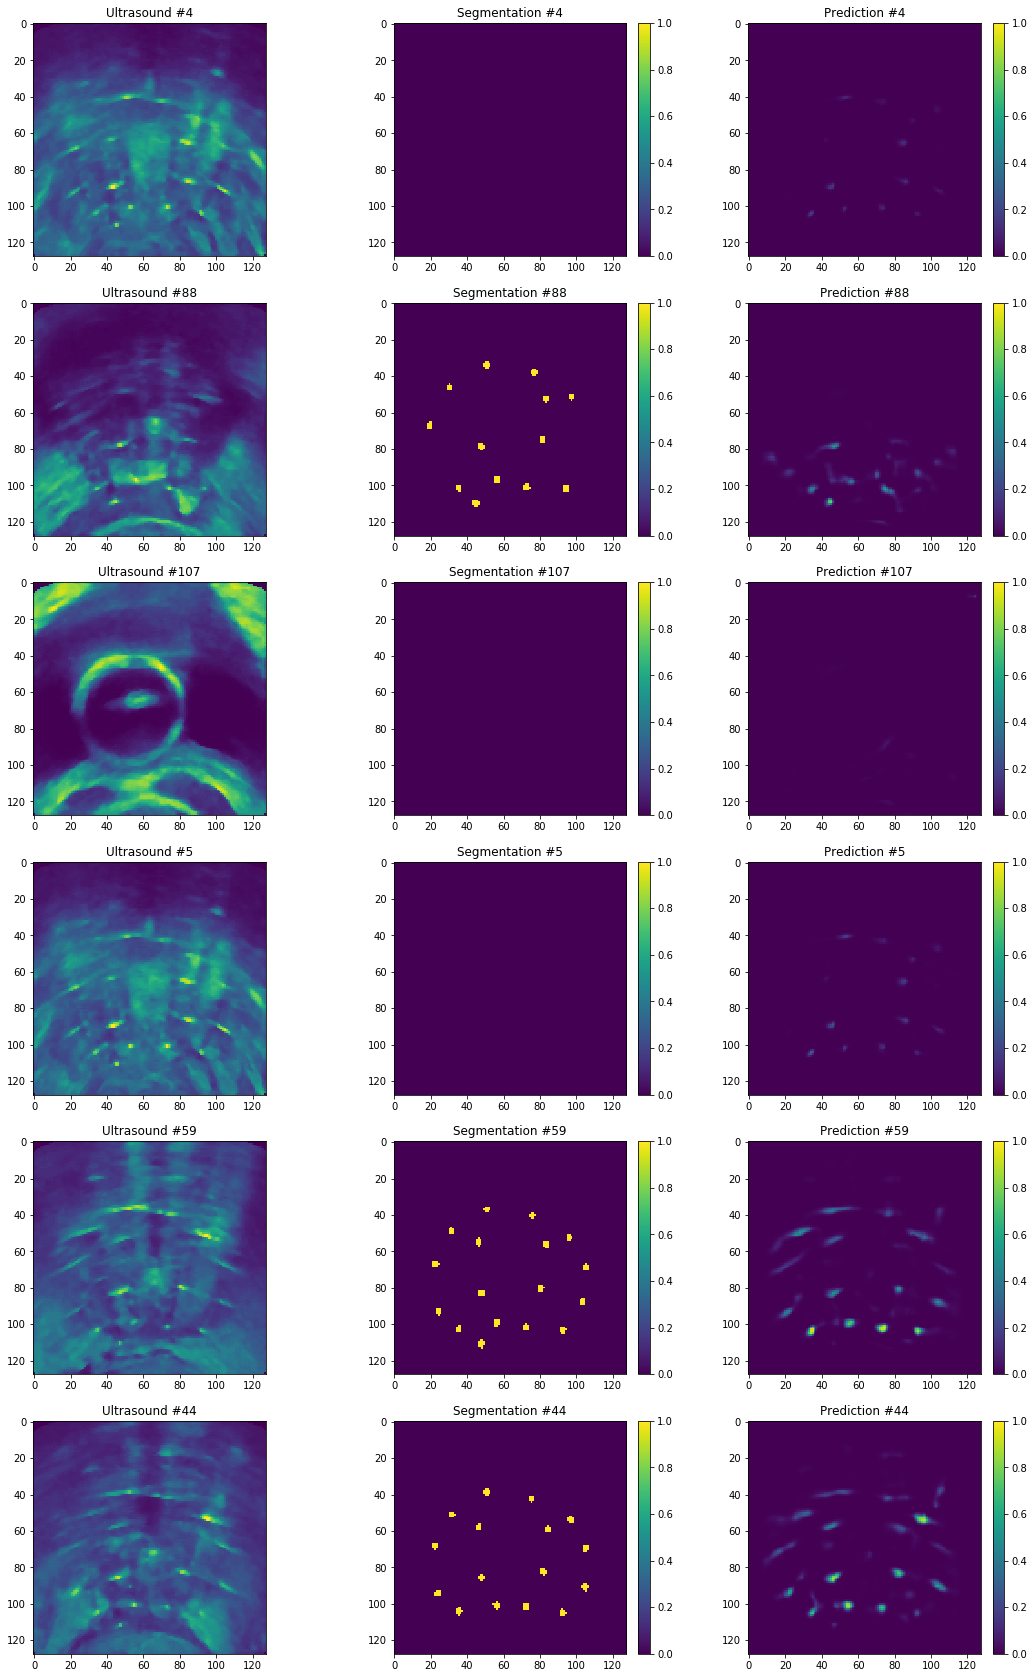

In [7]:
# Display sample results

num_test = testing_ultrasound.shape[0]
num_show = 6

indices = [i for i in range(num_test)]
sample_indices = sample(indices, num_show)

fig = plt.figure(figsize=(18, num_show*5))
for i in range(num_show):
    a0 = fig.add_subplot(num_show,3,i*3+1)
    img0 = a0.imshow(testing_ultrasound[sample_indices[i], :, :].astype(np.float32))
    a0.set_title("Ultrasound #{}".format(sample_indices[i]))
    a1 = fig.add_subplot(num_show,3,i*3+2)
    img1 = a1.imshow(testing_segmentation[sample_indices[i], :, :, 0], vmin=0.0, vmax=1.0)
    a1.set_title("Segmentation #{}".format(sample_indices[i]))
    c = fig.colorbar(img1, fraction=0.046, pad=0.04)
    a2 = fig.add_subplot(num_show,3,i*3+3)
    img2 = a2.imshow(testing_prediction[sample_indices[i], :, :, 1], vmin=0.0, vmax=1.0)
    a2.set_title("Prediction #{}".format(sample_indices[i]))
    c = fig.colorbar(img2, fraction=0.046, pad=0.04)

In [8]:
# Save notebook so all output is archived by the next cell

'''

from IPython.display import Javascript
script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''
Javascript(script)

'''

SyntaxError: invalid syntax (<ipython-input-8-7192b768d93b>, line 7)

In [ ]:
# Export HTML copy of this notebook

'''
notebook_file_name = this_notebook_name + "_" + train_timestamp + ".html"
notebook_fullname = os.path.join(notebooks_save_fullpath, notebook_file_name)

os.system("jupyter nbconvert --to html " + this_notebook_name + " --output " + notebook_fullname)
print("Notebook saved to: {}".format(notebook_fullname))

'''